In [34]:
import numpy as np
from math import sqrt
import skimage.io as io
import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian
from skimage import transform
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage
from skimage.measure import ransac
import pandas as pd
from sklearn.linear_model import RANSACRegressor

import matplotlib.pyplot as plt
from matplotlib import axes
from matplotlib import figure

plt.rcParams["figure.dpi"] = 300


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


4.111111111111111
4.111111111111111
6.444444444444445
4.111111111111111
4.111111111111111
6.444444444444445
3.3333333333333335
3.3333333333333335
3.3333333333333335
2.5555555555555554
2.5555555555555554
2.5555555555555554
4.111111111111111
3.3333333333333335


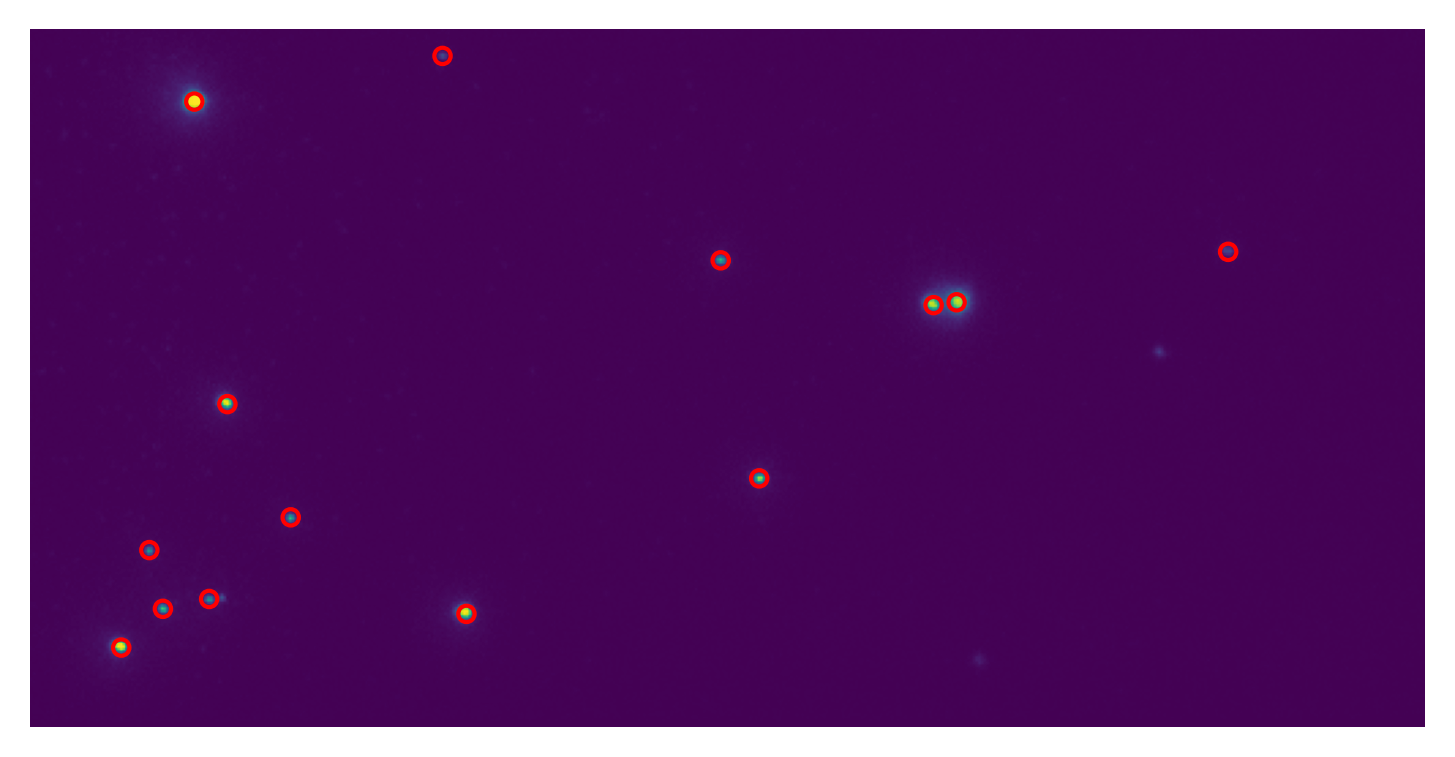

In [46]:
img = io.imread(
    "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/beads_246_fret_channel.tif"
)
movie_blob = blob_doh(
    img,
    min_sigma=1,
    max_sigma=8,
    threshold=0.0003,
)
# seq_centers = blob_doh(
#     img,
#     min_sigma=30,
#     max_sigma=500,
#     threshold=0.001,
# )

fig, ax = plt.subplots()
ax.imshow(img)
i = 0
CM = []
r = 3
[h, w] = img.shape
for blob in movie_blob:
    y, x, r = blob
    print(r)
    if y > r and y < (h - r) and x > r and x < (w - r):
        CM.append(
            ndimage.measurements.center_of_mass(
                img[int(y - r) : int(y + r), int(x - r) : int(x + r)]
            )
        )
        CM[i] = list(np.add(CM[i], [y - r, x - r]))
        x1, y1 = CM[i]
        c = plt.Circle([y1, x1], 3, color="red", linewidth=1, fill=False)
        ax.add_patch(c)
        i += 1
ax.set_axis_off()
plt.show()
fig.savefig(
    "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/movie_blob.tif"
)


In [169]:
# img = io.imread(
#     "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/movie_min_projection_246.tif"
# )
# seq_blobs = blob_doh(img, min_sigma=10, max_sigma=50, num_sigma=10, threshold=.01)


def blob_detection(img_path, min_sigma, max_sigma, threshold):
    img = io.imread(img_path)
    blob = blob_doh(img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold)
    i = 0
    r = 3
    centers = []
    h, w = img.shape
    for blob in blob:
        y, x, d = blob
        if y > r and y < (h - r) and x > r and x < (w - r):
            centers.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r + 1), int(x - r) : int(x + r + 1)]
                )
            )
            centers[i] = list(np.add(centers[i], [x - r, y - r]))
            # x1, y1 = centers[i]
            # c = plt.Circle([y1, x1], 3, color="red", linewidth=1, fill=False)
            # ax.add_patch(c)
            i += 1
    return np.array(centers)


# movie_blob = blob_doh(img, min_sigma=1, max_sigma=5, threshold=0.001)
# fig, ax = plt.subplots()
# ax.imshow(img)
# i = 0
# CM = []
# r = 3
# [h, w] = img.shape
# for blob in movie_blob:
#     y, x, r = blob
#     if y > r and y < (h - r) and x > r and x < (w - r):
#         CM.append(
#             ndimage.measurements.center_of_mass(
#                 img[int(y - r) : int(y + r), int(x - r) : int(x + r)]
#             )
#         )
#         CM[i] = list(np.add(CM[i], [y - r, x - r]))
#         x1, y1 = CM[i]
#         c = plt.Circle([y1, x1], 3, color="red", linewidth=1, fill=False)
#         ax.add_patch(c)
#         i += 1
# ax.set_axis_off()
# plt.show()
# fig.savefig(
#     "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/movie_blob.tif"
# )

movie_centers = blob_detection(
    "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/movie_min_projection_246.tif",
    min_sigma=1,
    max_sigma=5,
    threshold=0.001,
)

seq_centers = blob_detection(
    "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/min_projection_246.tif",
    min_sigma=10,
    max_sigma=50,
    threshold=0.005,
)

# print(movie_centers)
# print(movie_centers.shape)
# print(seq_centers)
# print(seq_centers.shape)


class PolyTrans(transform.PolynomialTransform):
    def estimate(*data):
        return transform.PolynomialTransform.estimate(*data, order=1)


res_tb = pd.read_csv('/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/Results.csv')
sample_num = int(len(res_tb) / 2)
src = np.column_stack((np.array(res_tb['XM'][0:sample_num]), np.array(res_tb['YM'][0:sample_num])))
dst = np.column_stack((np.array(res_tb['XM'][sample_num:]), np.array(res_tb['YM'][sample_num:])))

print(src)
print(dst)



# print(movie_centers[movie_centers[:, 0].argsort()])
# print(seq_centers[seq_centers[:, 0].argsort()])
movie_centers = movie_centers[movie_centers[:, 0].argsort()]
seq_centers = seq_centers[seq_centers[:, 0].argsort()]

model, inliers = ransac(
    (movie_centers, seq_centers),
    PolyTrans,
    4,
    5,
    initial_inliers=np.ones(len(movie_centers), dtype=bool),
    stop_probability=0.9,
)
print(inliers)

# model_r, inliers_r = ransac(
#     (movie_centers, seq_centers),
#     PolyTrans,
#     4,
#     5,
#     initial_inliers=np.ones(len(movie_centers), dtype=bool),
#     stop_probability=0.9,
# )

# bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# mathces = bf.match(src, dst)
# print(mathces)

# print(inliers)
# print(inliers_r)

# k = 0
# max_iter = 1e3
# max_matched = 0
# while k < max_iter:
#     model, inliers = ransac(
#         (movie_centers, seq_centers),
#         PolyTrans,
#         4,
#         10,
#         initial_inliers=np.ones(len(movie_centers), dtype=bool),
#         stop_probability=0.95,
#     )
    
#     if len(np.where(inliers == True)[0]) > max_matched:
#         # print(inliers)
#         # print(np.where(inliers == True))
#         max_matched = len(np.where(inliers == True)[0])
#         movie_centers_inliers = movie_centers[np.where(inliers == True)[0]]
#         seq_centers_inliers = seq_centers[np.where(inliers == True)[0]]
#     np.random.shuffle(seq_centers)
#     k += 1
# print(movie_centers_inliers)
# print(seq_centers_inliers)

# res = model(movie_centers)
# print(res)
# print(seq_centers)
    # if len(movie_centers_inliers) < 5:
    #     np.random.shuffle(seq_centers)
    # else:
    #     seq_centers_inliers = seq_centers[np.where(inliers == True)[0]]
    #     print(movie_centers_inliers)
    #     print(seq_centers_inliers)
    #     res = model(movie_centers)
    #     print(res)
    #     print(seq_centers)
    #     break
    # print(movie_centers_inliers)
# seq_centers_inliers = seq_centers[np.where(inliers_r == True)[0]]
# print(seq_centers_inliers)


[[ 61.038  26.231]
 [ 71.885 136.885]
 [267.833 164.611]
 [159.195 213.771]
 [ 33.    226.5  ]]
[[ 529.858  293.641]
 [ 602.434  956.69 ]
 [1771.721 1123.962]
 [1127.841 1419.024]
 [ 374.257 1489.663]]
[False False False False False False False False  True False]


5
5
20
20


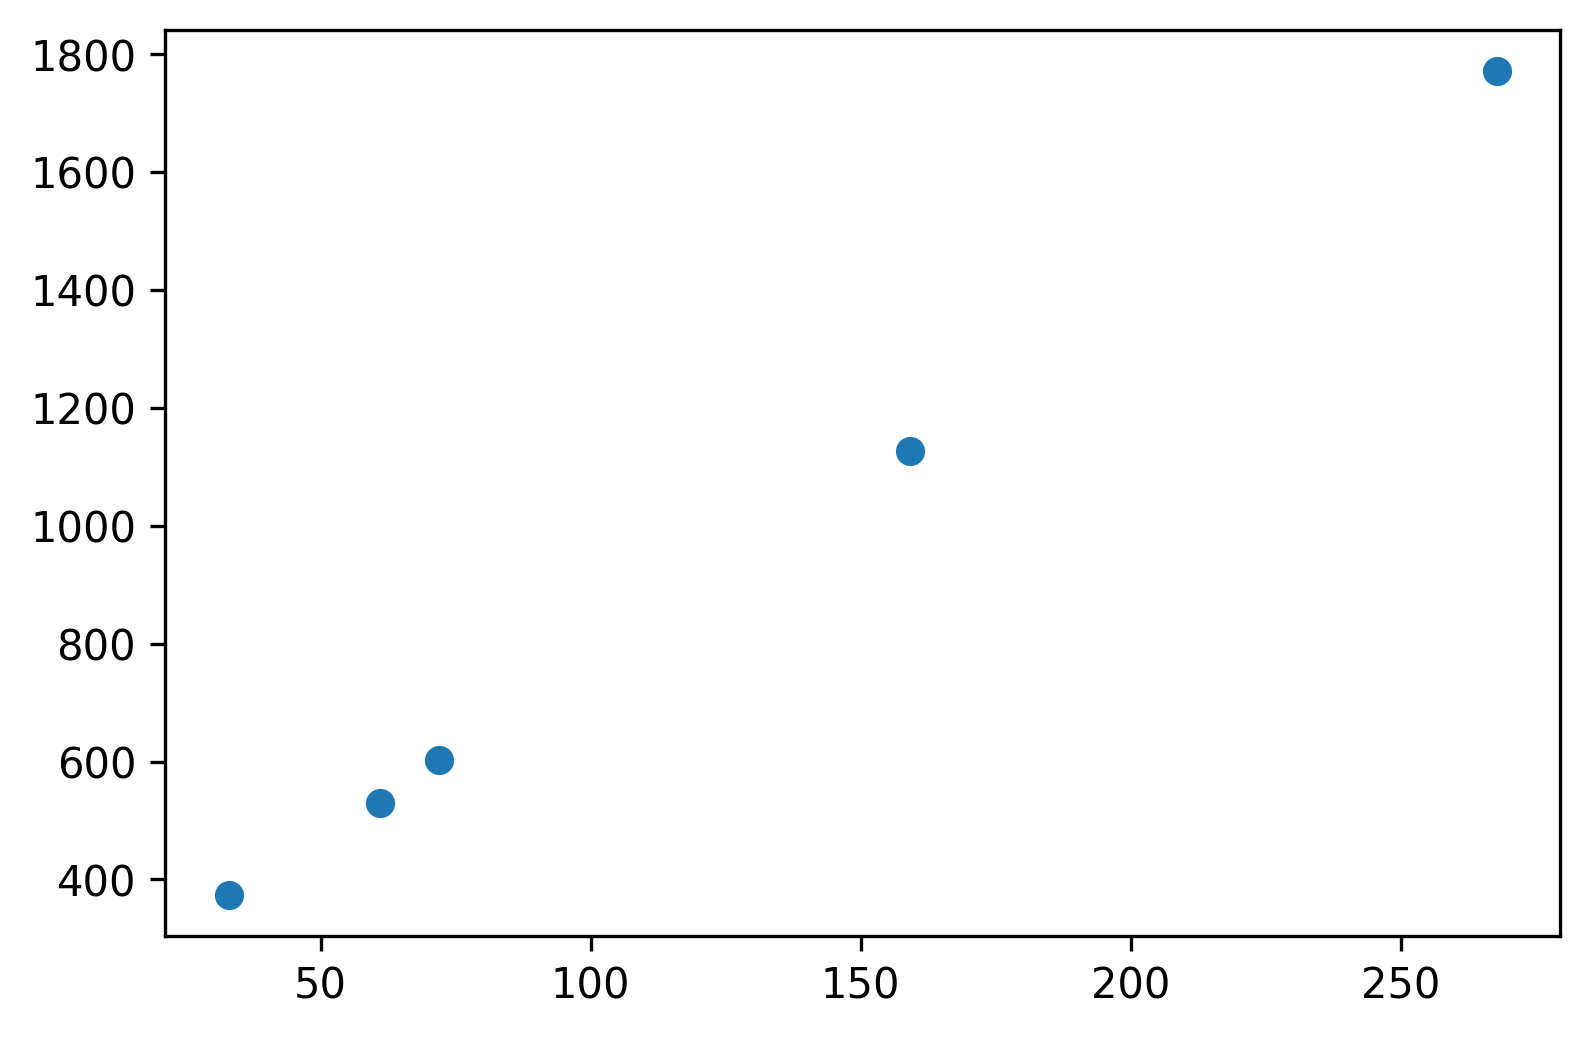

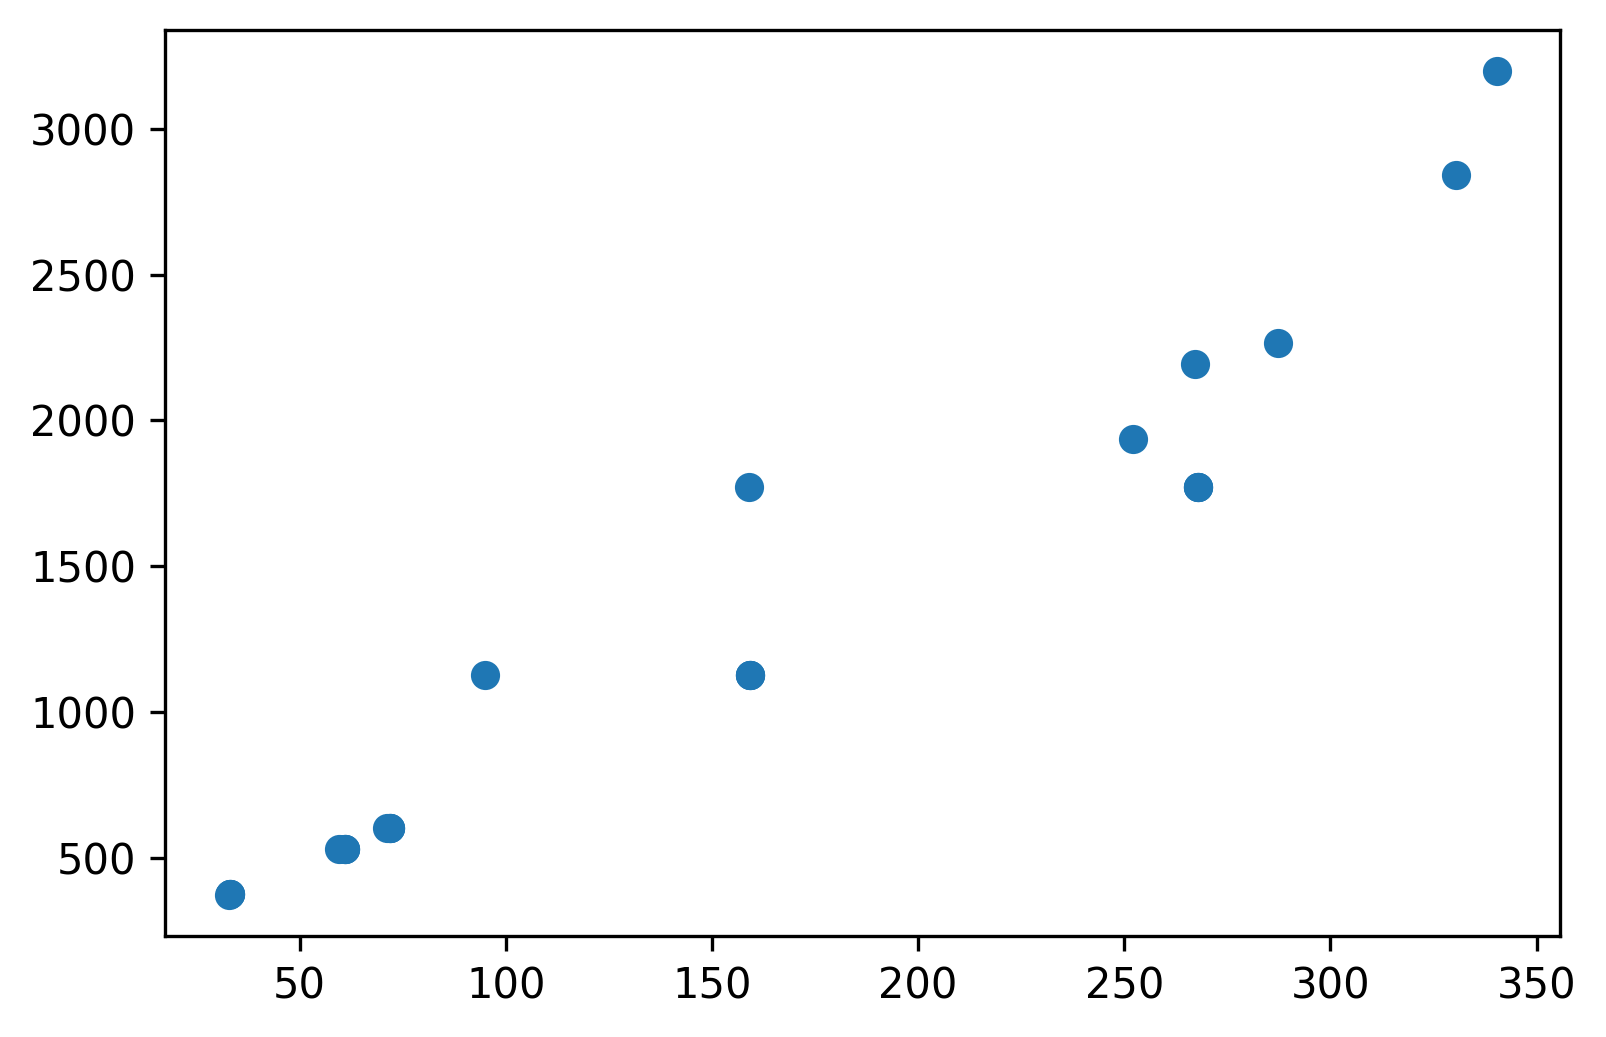

25
25
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False]


In [172]:
res_tb = pd.read_csv('/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/Results.csv')
sample_num = int(len(res_tb) / 2)
src = np.column_stack((np.array(res_tb['XM'][0:sample_num]), np.array(res_tb['YM'][0:sample_num])))
dst = np.column_stack((np.array(res_tb['XM'][sample_num:]), np.array(res_tb['YM'][sample_num:])))

print(len(src))
print(len(dst))
print(len(movie_centers))
print(len(seq_centers))

plt.figure()
plt.scatter(src[:, 0], dst[:, 0])
plt.show()

movie_centers = np.concatenate((src, movie_centers))
seq_centers = np.concatenate((dst, seq_centers))
# print(np.concatenate((src, movie_centers)))
plt.figure()
plt.scatter(movie_centers[:, 0], seq_centers[:, 0])
plt.show()
print(len(movie_centers))
print(len(seq_centers))
model, inliers = ransac(
    (movie_centers, seq_centers),
    PolyTrans,
    4,
    5,
    initial_inliers=np.ones(len(movie_centers), dtype=bool),
    stop_probability=0.9,
)
print(inliers)

[[ 32.7821708 ]
 [ 59.65528791]
 [ 71.19235669]
 [ 94.9600154 ]
 [159.01880505]
 [252.22195513]
 [267.17066209]
 [287.17801496]
 [330.47633259]
 [340.37429367]]
[[ 372.9530906 ]
 [ 529.00200369]
 [ 602.14199065]
 [1128.        ]
 [1771.19362558]
 [1937.00352649]
 [2193.        ]
 [2264.        ]
 [2841.94552496]
 [3198.00296546]]


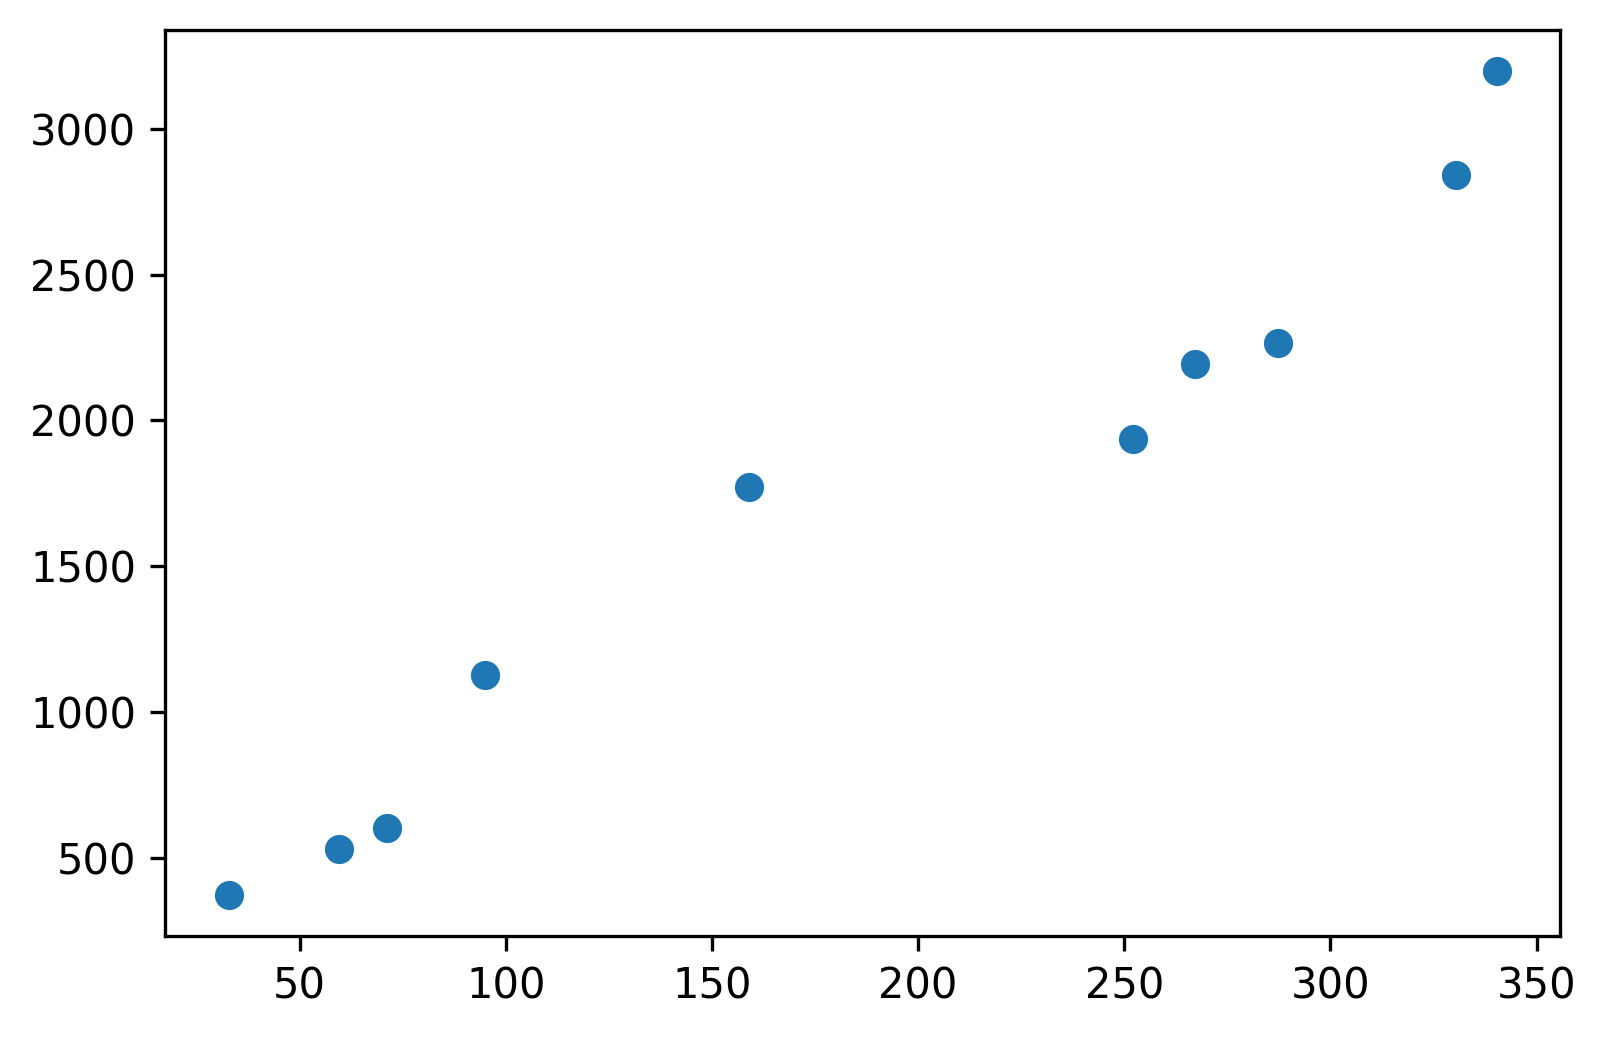

0.9555446497476049

In [158]:
# print(movie_centers)
# print(seq_centers)
movie_centers = movie_centers[movie_centers[:, 0].argsort()]
seq_centers = seq_centers[seq_centers[:, 0].argsort()]
movie_x = movie_centers[:, 0].reshape(-1, 1)
seq_x = seq_centers[:, 0].reshape(-1, 1)
print(movie_x)
print(seq_x)

plt.figure()
plt.scatter(movie_x, seq_x)
# plt.scatter(src.T[0], tform(src).T[0])
plt.show()
reg = RANSACRegressor(random_state=0).fit(movie_x, seq_x)
reg.score(movie_x, seq_x)

In [8]:
io.imsave("C:/Users/Anton/Documents/Jupyter home/ExampleData/Pos246/test.tif", img)


In [6]:
print(CM)


[[292.63415151129766, 528.6341515112977], [955.6341515112977, 601.6341515112977], [1122.6341515112977, 1770.6341515112977], [1418.6341515112977, 1126.6341515112977], [1488.6341515112977, 373.63415151129766]]


In [41]:
[x, y] = img.shape


In [65]:
x = [0, 1]
x.append(1)
print(x + x)


[0, 1, 1, 0, 1, 1]
